# 應用場景3:使用 EfficientNet 遷移學習進行狗品種辨識

### 以下程式執行時，請開啟GPU

In [16]:
# IMG_SIZE 的大小和所選擇的EfficientNet有關，本範例使用 EfficientNetB0，其影像輸入大小為224X224
IMG_SIZE = 260

### 載入資料集

In [17]:
import tensorflow as tf               # 載入tensorflow 模組
import tensorflow_datasets as tfds    # 載入tensorflow dataset 模組

batch_size = 512                       # mini-batch 大小為64

dataset_name = "stanford_dogs"        # 所選擇的資料集為 stanford dog dataests

(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True  # 載入資料集
)
NUM_CLASSES = ds_info.features["label"].num_classes  # 使用 ds_info 取得類別數量


In [18]:
print(ds_info)

tfds.core.DatasetInfo(
    name='stanford_dogs',
    version=0.2.0,
    description='The Stanford Dogs dataset contains images of 120 breeds of dogs from around
the world. This dataset has been built using images and annotation from
ImageNet for the task of fine-grained image categorization. There are
20,580 images, out of which 12,000 are used for training and 8580 for
testing. Class labels and bounding box annotations are provided
for all the 12,000 images.',
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
        'objects': Sequence({
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        }),
    }),
    total_num_examples=20580,
    splits={
        'test': 8580,
        'train': 12000,
    },
    supervised_keys=('image'

In [19]:
size = (IMG_SIZE, IMG_SIZE)   # 影像大小設為 224X224
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label)) # 將訓練資料集影像大小調整成符合網路輸入大小
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))   # 將測試資料集影像大小調整成符合網路輸入大小

### 資料視覺化¶

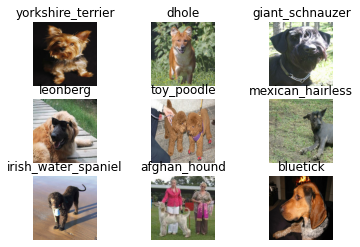

In [20]:
import matplotlib.pyplot as plt # 載入matplotlib模組

# 將label由整數轉成字串
def format_label(label): 
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]

# 顯示圖片內容及標籤
label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")

### 資料擴增¶

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15), # 隨機旋轉
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1), # 隨機平移
        layers.RandomFlip(), # 隨機翻轉
        layers.RandomContrast(factor=0.1), #隨機對比增強
    ],
    name="img_augmentation",
)

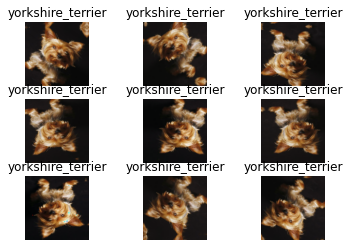

In [22]:
for image, label in ds_train.take(1):
    for i in range(9):  # 隨機產生九張經過 img_augmentation的影像
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")


### 預備資料輸入¶

In [23]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)

### 訓練歷程繪圖函式

In [24]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


### 從預訓練權重進行遷移學習

In [25]:
from tensorflow.keras.applications import EfficientNetB2

def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB2(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model


### 鎖定基底模型，只訓練最後一層¶

31801344/31790344 [==============================] - 1s 0us/step
Epoch 1/10
23/23 - 100s - loss: 2.7486 - accuracy: 0.4382 - val_loss: 0.9452 - val_accuracy: 0.8252 - 100s/epoch - 4s/step
Epoch 2/10
23/23 - 73s - loss: 1.7567 - accuracy: 0.6021 - val_loss: 0.9365 - val_accuracy: 0.8179 - 73s/epoch - 3s/step
Epoch 3/10
23/23 - 74s - loss: 1.4713 - accuracy: 0.6353 - val_loss: 0.9329 - val_accuracy: 0.8240 - 74s/epoch - 3s/step
Epoch 4/10
23/23 - 85s - loss: 1.2891 - accuracy: 0.6628 - val_loss: 0.8502 - val_accuracy: 0.8290 - 85s/epoch - 4s/step
Epoch 5/10
23/23 - 85s - loss: 1.1820 - accuracy: 0.6743 - val_loss: 0.7859 - val_accuracy: 0.8225 - 85s/epoch - 4s/step
Epoch 6/10
23/23 - 74s - loss: 1.1093 - accuracy: 0.6926 - val_loss: 0.7349 - val_accuracy: 0.8219 - 74s/epoch - 3s/step
Epoch 7/10
23/23 - 74s - loss: 1.0430 - accuracy: 0.7013 - val_loss: 0.6589 - val_accuracy: 0.8293 - 74s/epoch - 3s/step
Epoch 8/10
23/23 - 73s - loss: 1.0074 - accuracy: 0.7086 - val_loss: 0.6150 - val_accu

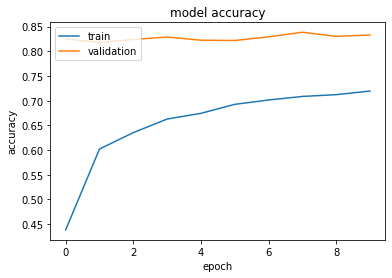

In [26]:
model = build_model(num_classes=NUM_CLASSES)

epochs = 10  # @param {type: "slider", min:8, max:80}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)
plot_hist(hist)

  ### 解除基底模型，訓練最後10層¶

Epoch 1/10
23/23 - 100s - loss: 0.8473 - accuracy: 0.7452 - val_loss: 0.5103 - val_accuracy: 0.8514 - 100s/epoch - 4s/step
Epoch 2/10
23/23 - 85s - loss: 0.7822 - accuracy: 0.7674 - val_loss: 0.4777 - val_accuracy: 0.8588 - 85s/epoch - 4s/step
Epoch 3/10
23/23 - 86s - loss: 0.7720 - accuracy: 0.7653 - val_loss: 0.4617 - val_accuracy: 0.8622 - 86s/epoch - 4s/step
Epoch 4/10
23/23 - 74s - loss: 0.7294 - accuracy: 0.7785 - val_loss: 0.4523 - val_accuracy: 0.8628 - 74s/epoch - 3s/step
Epoch 5/10
23/23 - 86s - loss: 0.7428 - accuracy: 0.7756 - val_loss: 0.4465 - val_accuracy: 0.8643 - 86s/epoch - 4s/step
Epoch 6/10
23/23 - 75s - loss: 0.7418 - accuracy: 0.7743 - val_loss: 0.4435 - val_accuracy: 0.8655 - 75s/epoch - 3s/step
Epoch 7/10
23/23 - 75s - loss: 0.7326 - accuracy: 0.7791 - val_loss: 0.4416 - val_accuracy: 0.8656 - 75s/epoch - 3s/step
Epoch 8/10
23/23 - 75s - loss: 0.7199 - accuracy: 0.7816 - val_loss: 0.4411 - val_accuracy: 0.8657 - 75s/epoch - 3s/step
Epoch 9/10
23/23 - 75s - loss:

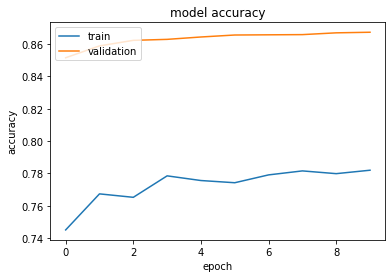

In [27]:
def unfreeze_model(model):
    # We unfreeze the top 10 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-10:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 10  # @param {type: "slider", min:8, max:50}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)
plot_hist(hist)

### 模型存檔¶

In [28]:
model.save("my-dog-efficientNet")

KeyError: ignored

### 模型載入測試¶

In [ ]:
import numpy as np 

reconstructed_model = tf.keras.models.load_model("my-dog-efficientNet")

reconstructed_model.fit(ds_train)



### 壓縮及下載模型供未來使用

### 測試模型

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

!wget https://upload.wikimedia.org/wikipedia/commons/f/f8/Full_attention_%288067543690%29.jpg -O test.jpg

img_path = 'test.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = reconstructed_model.predict(x)

o = tf.argmax(preds[0])
print(format_label(int(o)))